# Геокоддер

In [ ]:
from public_transport_osmnx.osmnx import geocode_to_gdf

In [ ]:
gdf = geocode_to_gdf('Санкт-Петербург', which_result=1, tag_filter="type")

In [ ]:
gdf

# Граф

In [1]:
import public_transport_osmnx.osmnx as ox

In [2]:
g, r, s, p = ox.graph_from_place("Москва", simplify=True, retain_all=True, network_types=["bus"])

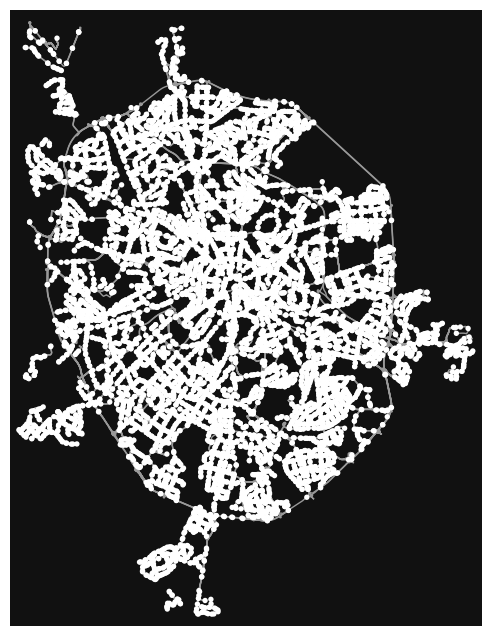

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
ox.plot_graph(g)

In [ ]:
g, r, s, p = ox.graph_from_place("Санкт-Петербург", simplify=True, retain_all=True, network_type="bus")

In [ ]:
ox.plot_graph(g)

# GeoDataFrame

In [ ]:
import numpy as np

In [ ]:
gdf_nodes, gdf_relationships = ox.graph_to_gdfs(g)

In [ ]:
gdf_nodes.reset_index(inplace=True)
gdf_relationships.reset_index(inplace=True)

In [ ]:
gdf_nodes["geometry_wkt"] = gdf_nodes["geometry"].apply(lambda x: x.wkt)
gdf_relationships["geometry_wkt"] = gdf_relationships["geometry"].apply(lambda x: x.wkt)

In [ ]:
gdf_relationships

# Neo4j

In [14]:
import neo4j
import geopandas as gpd


NEO4J_URI = "neo4j://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "123456789"

driver = neo4j.GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

In [15]:
driver.verify_connectivity()

## Подсчет количества узлов в графе

In [ ]:
CYPHER_QUERY = """
MATCH (n) RETURN COUNT(n) AS node_count
"""

def get_node_count(tx):
    results = tx.run(CYPHER_QUERY)
    df = results.to_df()
    return df

## Проверка на наличие графа в БД

In [ ]:
COUNT_QUERY = """
MATCH (n) RETURN COUNT(n) AS node_count
"""

def is_clear(tx):
    results = tx.run(COUNT_QUERY)
    df = results.to_df()
    return df.loc[0, "node_count"] == 0

In [ ]:
with driver.session() as session:
    df = session.execute_read(is_clear)

In [ ]:
print(df)

## Добавление графа в БД

Определяем запросы

In [ ]:
# First, define Cypher queries to create constraints and indexes

constraint_query = "CREATE CONSTRAINT IF NOT EXISTS FOR (i:Intersection) REQUIRE i.osmid IS UNIQUE"

rel_index_query = "CREATE INDEX IF NOT EXISTS FOR ()-[r:ROAD_SEGMENT]-() ON r.osmids"

address_constraint_query = "CREATE CONSTRAINT IF NOT EXISTS FOR (a:Address) REQUIRE a.id IS UNIQUE"

point_index_query = "CREATE POINT INDEX IF NOT EXISTS FOR (i:Intersection) ON i.location"

# Cypher query to import our road network nodes GeoDataFrame

node_query = '''
    UNWIND $rows AS row
    WITH row WHERE row.osmid IS NOT NULL
    MERGE (s:Stop {osmid: row.osmid})
        SET s.location = 
         point({latitude: row.y, longitude: row.x }),
            s.name = row.name,
            s.highway = row.highway,
            s.public_transport = row.public_transport,
            s.routes = row.routes,
            s.tram = row.tram,
            s.bus = row.bus,
            s.geometry_wkt = row.geometry_wkt,
            s.street_count = toInteger(row.street_count)
    RETURN COUNT(*) as total
    '''

# Cypher query to import our road network relationships GeoDataFrame

rels_query = '''
    UNWIND $rows AS path
    MATCH (u:Stop {osmid: path.u})
    MATCH (v:Stop {osmid: path.v})
    MERGE (u)-[r:ROUTE_SEGMENT {osmid: path.osmid}]->(v)
        SET r.name = path.name,
            r.highway = path.highway,
            r.railway = path.railway,
            r.oneway = path.oneway,
            r.lanes = path.lanes,
            r.max_speed = path.maxspeed,
            r.geometry_wkt = path.geometry_wkt,
            r.length = toFloat(path.length)
    RETURN COUNT(*) AS total
    '''

Определяем функции

In [ ]:
def create_constraints(tx):
    result = tx.run(constraint_query)
    result = tx.run(rel_index_query)
    result = tx.run(address_constraint_query)
    result = tx.run(point_index_query)

In [ ]:
# Function to batch our GeoDataFrames

def insert_data(tx, query, rows, batch_size=10000):
    total = 0
    batch = 0
    
    while batch * batch_size < len(rows):
        results = tx.run(query, parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')}).data()
        print(results)
        total += results[0]['total']
        batch += 1

Запись в графа в БД

In [ ]:
# Changing GeoDataFrame to insert data
gdf_nodes, gdf_relationships = ox.graph_to_gdfs(g)
gdf_nodes.reset_index(inplace=True)
gdf_relationships.reset_index(inplace=True)
gdf_nodes["geometry_wkt"] = gdf_nodes["geometry"].apply(lambda x: x.wkt)
gdf_relationships["geometry_wkt"] = gdf_relationships["geometry"].apply(lambda x: x.wkt)

# Run our constraints queries and nodes GeoDataFrame import

with driver.session() as session:
    session.execute_write(create_constraints)
    session.execute_write(insert_data, node_query, gdf_nodes.drop(columns=["geometry"]))

# Run our relationships GeoDataFrame import

with driver.session() as session:
    session.execute_write(insert_data, rels_query, gdf_relationships.drop(columns=["geometry"]))

## Получение графа из БД

Определяем запросы

In [19]:
bbox_query = lambda node_name: 'point.withinBBox(' + node_name + '.location, point({longitude: $minx, latitude: $miny }), point({longitude: $maxx, latitude: $maxy}))'

node_get_bbox_query = lambda bbox_query: f'''
MATCH (s:Stop)
WHERE {bbox_query('s')}
RETURN 
s.osmid AS osmid, 
s.location.longitude AS x, 
s.location.latitude AS y, 
s.name AS name, 
s.public_transport AS public_transport, 
s.tram AS tram, 
s.bus AS bus, 
s.routes AS routes, 
s.street_count AS street_count, 
s.geometry_wkt AS geometry_wkt
'''

rels_get_bbox_query = lambda bbox_query: f'''
MATCH (u:Stop)-[r:ROUTE_SEGMENT]->(v:Stop)
WHERE {bbox_query('u')}
AND {bbox_query('v')}
RETURN
u.osmid AS u, 
v.osmid AS v, 
r.osmid AS osmid, 
r.name AS name, 
r.highway AS higway, 
r.lanes AS lanes, 
r.maxspeed AS maxspeed, 
r.railway AS railway, 
r.oneway AS oneway, 
r.reversed AS reversed, 
r.length AS length, 
r.geometry_wkt AS geometry_wkt
'''

node_get_query = f'''
MATCH (s:Stop)
RETURN 
s.osmid AS osmid, 
s.location.longitude AS x, 
s.location.latitude AS y, 
s.name AS name, 
s.public_transport AS public_transport, 
s.tram AS tram, 
s.bus AS bus, 
s.routes AS routes, 
s.street_count AS street_count, 
s.geometry_wkt AS geometry_wkt
'''

rels_get_query = f'''
MATCH (u:Stop)-[r:ROUTE_SEGMENT]->(v:Stop)
RETURN
u.osmid AS u, 
v.osmid AS v, 
r.osmid AS osmid, 
r.name AS name, 
r.highway AS higway, 
r.lanes AS lanes, 
r.maxspeed AS maxspeed, 
r.railway AS railway, 
r.oneway AS oneway, 
r.reversed AS reversed, 
r.length AS length, 
r.geometry_wkt AS geometry_wkt
'''

In [22]:
def get_data(tx, query, bounds=None):
    if bounds is None:
        results = tx.run(query)
    else:
        minx, miny, maxx, maxy = bounds
        results = tx.run(query, parameters={"minx": minx, "miny": miny, "maxx": maxx, "maxy": maxy})
    df = results.to_df()
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry_wkt'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf = gdf.drop(columns=["geometry"])
    return gdf

### С полигоном

In [21]:
from shapely import Polygon

custom_border = [(29, 59), (29, 61), (31, 61), (31, 59), (29, 59)]
custom_polygon = Polygon(custom_border)
custom_bounds = custom_polygon.bounds

with driver.session() as session:
    node_get_query = node_get_bbox_query(bbox_query)
    gdf_nodes = session.execute_read(get_data, node_get_query, custom_bounds)
   
with driver.session() as session:
    rels_get_query = rels_get_bbox_query(bbox_query)
    gdf_relationships = session.execute_read(get_data, rels_get_query, custom_bounds)

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input '<': expected
  "ALTER"
  "CALL"
  "CREATE"
  "DEALLOCATE"
  "DELETE"
  "DENY"
  "DETACH"
  "DROP"
  "DRYRUN"
  "ENABLE"
  "FOREACH"
  "GRANT"
  "LOAD"
  "MATCH"
  "MERGE"
  "OPTIONAL"
  "REALLOCATE"
  "REMOVE"
  "RENAME"
  "RETURN"
  "REVOKE"
  "SET"
  "SHOW"
  "START"
  "STOP"
  "TERMINATE"
  "UNWIND"
  "USE"
  "USING"
  "WITH" (line 1, column 1 (offset: 0))
"<function <lambda> at 0x00000208254B1D30>"
 ^}

In [12]:
get_data(None, rels_get_query, [[]])


MATCH (u:Stop)-[r:ROUTE_SEGMENT]->(v:Stop)
WHERE point.withinBBox(u.location, point({longitude: $minx, latitude: $miny }), point({longitude: $maxx, latitude: $maxy}))
WHERE point.withinBBox(v.location, point({longitude: $minx, latitude: $miny }), point({longitude: $maxx, latitude: $maxy}))
RETURN
u.osmid AS u, 
v.osmid AS v, 
r.osmid AS osmid, 
r.name AS name, 
r.highway AS higway, 
r.lanes AS lanes, 
r.maxspeed AS maxspeed, 
r.railway AS railway, 
r.oneway AS oneway, 
r.reversed AS reversed, 
r.length AS length, 
r.geometry_wkt AS geometry_wkt



### Без полигона

Определяем функции

In [ ]:
def get_data(tx, query):
    results = tx.run(query)
    df = results.to_df()
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry_wkt'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf = gdf.drop(columns=["geometry"])
    return gdf

Получаем данные

In [ ]:
with driver.session() as session:
    gdf_nodes = session.execute_read(get_data, node_get_query)

In [ ]:
with driver.session() as session:
    gdf_relationships = session.execute_read(get_data, rels_get_query)

## Удаление графа из БД

In [ ]:
DELETE_QUERY = '''
MATCH (n)
WITH n LIMIT 10000
DETACH DELETE n
RETURN count(*);
'''

In [ ]:
with driver.session() as session:
    result = session.run(
        DELETE_QUERY
        )
    # df = result.to_df()

## Получение графа из полгигона